# Trinity Watershed

by: John Kucharksi | correspondance: johnkucharski@gmail.com | date: 05 March 2022
The notebook analyzes the spatial patterns of extreme precipitation events in the Trinity Watershed, using the Livneh daily precipitation data and USGS 4 digit hydrologic unit code watershed boundary shapefile.$^{1, 2}$ </br>
  
References: <br>
$^{1}$ Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392. <br>
$^{2}$ U.S. Geological Survey, 2020, National Waterboundary Dataset for 2 digit hydrologic Unit (HU) 02 (mid-atlantic), accessed April 11, 2020 at URL http://prd-tnm.s3-website-us-west-2.amazonaws.com/?prefix=StagedProducts/Hydrography/WBD/HU2/Shape/. ** 

**note: more information on the USGS National Hydrography program and products including the water boundary shape files, used in this analysis can be found here: https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products. 

## Data Processing
The first half of this notebook, processes the raw livneh data.

In [1]:


import os
import sys
from pathlib import Path 
from typing import List, Dict, Tuple
projpath: str = f'{Path(os.path.abspath("")).resolve().parent.parent}/' #'/Users/johnkucharski/Documents/source/locus/'
sys.path.insert(0, projpath)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import src.locus as locus
import src.livneh as livneh
from src.waterboundary import Waterboundary


### Folder Structure
The data for this analysis are stored in the following directory structure:

data/ </br>
&emsp;  |- input/ </br>
&emsp;  |&emsp; |- livneh/ </br>
&emsp;  |&emsp; |&emsp; '- prec.YEAR.nc (YEAR = 4-digit year [1915-2011])</br>
&emsp;  |&emsp; '- waterboundary/  </br>
&emsp;  |&emsp;  &emsp; '- WBD_XX_HU2_Shape/Shape/ (XX = 2-digit USGS HUC code) </br>
&emsp;  |&emsp;  &emsp; &emsp;  |- WBDHUZZ.shp (ZZ = 1 or 2-digit HUC code size) </br>
&emsp;  |&emsp;  &emsp; &emsp;  '- other related files (.shx, .cpg, .dbf, .sbn, etc.) </br>
&emsp;  '- output/ </br>
&emsp;   &emsp; '- trinity ** </br>
&emsp;   &emsp;  &emsp; |- ams/ </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_events.csv (N = duration in days) </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_grids.csv  (N = duration in days) </br>
&emsp;   &emsp;  &emsp; '- pds/ </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_events.csv (N = duration in days) </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_grids.csv (N = duration in days) </br>
&emsp;   &emsp;  &emsp; '- prec.YEAR.csv (YEAR = 4-digit year [1915, 2011])

**note: to generalize this the folder structure between the outputs and the northbranch folder (a HUC08) should include folders with the HUC 2, 4, and 6 names.




### Inputs

In [2]:
inputs: str = f'{projpath}data/input/'

The data being analyzed is daily gridded precipitation depths recorded from 1915 through 2011 in the North Branch of the Potomac Watershed in Western Maryland, USA. 
The data for each day contains the preciptation depth in all 130 livneh grid cells (1/16th of a degree of latitude/longitude) located within or intersected by the North Branch of the Potomac 8 digit Hydrologic Unit Code (HUC08) boundary.

### Outputs

In [3]:

output: str = f'{projpath}data/output/trinity/'

The output data from this notebook are livneh files that collectively contain the partial duration series (PDS) from a peak over threshold analysis, that yields of days in the livneh record in which the rainfall exceeds the minimum annual maximum basin average value.

In [5]:
huc_code: str = '1203'
fpath: str = f'{inputs}waterboundary/'
wbd = Waterboundary(path=fpath, code=huc_code).import_waterboundary()
wbd_area = wbd.iloc[0].AreaSqKm
wbd.head()

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,AreaSqKm,AreaAcres,GNIS_ID,Name,States,HUC4,Shape_Leng,Shape_Area,geometry
1,2,{7EFEC151-F98F-40AC-A4DD-89BD290594FD},None,None,None,None,2016-03-10,46386.73,11462400.29,0,Trinity,TX,1203,19.198457,4.439656,"POLYGON ((-97.39517 33.73451, -97.39442 33.734..."


Later the livneh grids are converted to polygons and clipped to the "wbd" watershed shape, this is a slow process. To speed it up first the netCDF livneh grids are clipped to a boundary box, created in the next cell.

In [6]:
buffer: float = 1/32
# bbox = [west, south, east, north] coordinates
bbox: List[float] = list(wbd.iloc[0].geometry.bounds)
bbox[0] = bbox[0] - buffer
bbox[1] = bbox[1] - buffer
bbox[2] = bbox[2] + buffer
bbox[3] = bbox[3] + buffer

Gathers the list of input .NetCDF file path (as strings) to process, and the output paths (as strings) for the processed .csv files.

In [7]:
srt_paths: List[str] = livneh.inputfilepaths(f'{inputs}', vars=['prec'], yrs=[i for i in range(1915, 2012)])
end_paths: List[str] = livneh.outputfilepaths(output, srt_paths)

In [8]:
ids = livneh.ids(srt_paths[0], boundarybox=bbox, wbd=wbd).drop(columns=['area_km2', 'area_weight'])
print(ids.shape)
ids.head()

,id,lat,lon,geometry
0,0,33.71875,-97.59375,POINT (-97.59375 33.71875)
1,1,33.71875,-97.53125,POINT (-97.53125 33.71875)
2,2,33.71875,-97.46875,POINT (-97.46875 33.71875)
3,3,33.71875,-97.40625,POINT (-97.40625 33.71875)
4,4,33.71875,-97.34375,POINT (-97.34375 33.71875)


Processes the the livneh precipitation .NetCDF files returning processed .csv files, for the area of interest.

In [10]:
print_msg = livneh.process_files(srt_paths, end_paths, bbox, wbd)
print(f'processed: {print_msg}')

processed: ['prec.1915.csv', 'prec.1916.csv', 'prec.1917.csv', 'prec.1918.csv', 'prec.1919.csv', 'prec.1920.csv', 'prec.1921.csv', 'prec.1922.csv', 'prec.1923.csv', 'prec.1924.csv', 'prec.1925.csv', 'prec.1926.csv', 'prec.1927.csv', 'prec.1928.csv', 'prec.1929.csv', 'prec.1930.csv', 'prec.1931.csv', 'prec.1932.csv', 'prec.1933.csv', 'prec.1934.csv', 'prec.1935.csv', 'prec.1936.csv', 'prec.1937.csv', 'prec.1938.csv', 'prec.1939.csv', 'prec.1940.csv', 'prec.1941.csv', 'prec.1942.csv', 'prec.1943.csv', 'prec.1944.csv', 'prec.1945.csv', 'prec.1946.csv', 'prec.1947.csv', 'prec.1948.csv', 'prec.1949.csv', 'prec.1950.csv', 'prec.1951.csv', 'prec.1952.csv', 'prec.1953.csv', 'prec.1954.csv', 'prec.1955.csv', 'prec.1956.csv', 'prec.1957.csv', 'prec.1958.csv', 'prec.1959.csv', 'prec.1960.csv', 'prec.1961.csv', 'prec.1962.csv', 'prec.1963.csv', 'prec.1964.csv', 'prec.1965.csv', 'prec.1966.csv', 'prec.1967.csv', 'prec.1968.csv', 'prec.1969.csv', 'prec.1970.csv', 'prec.1971.csv', 'prec.1972.csv', 'p

Takes the processed .csv livneh files for the area of interest, and returns partial duration (PDS) and annual maximum series (AMS) for the specified list of durations in days.

In [11]:
print_msg = livneh.compute_series(end_paths, [1, 2, 3])
print(print_msg)

['success', 'success', 'success']


In [12]:
df = pd.read_csv(f'{output}ams/1dy_grids.csv', index_col=[0])
print(df.shape)
df.head()

(97, 1297)


,0,1,2,3,4,5,6,7,8,9,...,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296
1915-08-17,24.625,28.350,30.975,35.500,36.900,36.975,39.550,40.825,41.700,40.825,...,92.950,93.25,90.275,89.825,98.525,96.10,93.125,90.75,86.775,0.0
1916-03-31,30.200,32.450,37.975,44.075,47.425,47.775,50.525,53.025,53.000,52.025,...,23.825,29.45,34.400,34.575,23.125,27.85,33.325,37.35,37.875,0.0
1917-11-27,27.500,26.375,26.600,24.625,25.825,26.975,27.750,27.175,26.650,26.875,...,4.200,4.35,4.250,4.250,4.000,4.15,4.275,4.35,4.400,0.0
1918-11-07,20.150,24.825,26.700,26.200,28.200,28.100,28.900,29.625,29.375,31.200,...,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.00,0.000,0.0
1919-10-21,16.725,19.400,19.850,23.300,23.350,20.150,20.750,21.450,21.675,21.125,...,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.00,0.000,0.0


In [13]:
df_clustered = locus.storm_centers(df) 
print(df_clustered.shape)
df_clustered.head()

(97, 1298)


,0,1,2,3,4,5,6,7,8,9,...,1288,1289,1290,1291,1292,1293,1294,1295,1296,cluster
1915-08-17,24.625,28.350,30.975,35.500,36.900,36.975,39.550,40.825,41.700,40.825,...,93.25,90.275,89.825,98.525,96.10,93.125,90.75,86.775,0.0,4
1916-03-31,30.200,32.450,37.975,44.075,47.425,47.775,50.525,53.025,53.000,52.025,...,29.45,34.400,34.575,23.125,27.85,33.325,37.35,37.875,0.0,0
1917-11-27,27.500,26.375,26.600,24.625,25.825,26.975,27.750,27.175,26.650,26.875,...,4.35,4.250,4.250,4.000,4.15,4.275,4.35,4.400,0.0,3
1918-11-07,20.150,24.825,26.700,26.200,28.200,28.100,28.900,29.625,29.375,31.200,...,0.00,0.000,0.000,0.000,0.00,0.000,0.00,0.000,0.0,0
1919-10-21,16.725,19.400,19.850,23.300,23.350,20.150,20.750,21.450,21.675,21.125,...,0.00,0.000,0.000,0.000,0.00,0.000,0.00,0.000,0.0,3


In [ ]:
# grids DB from locus,ipynb in old dataset.
# points = pd.read_csv(inputs + 'prec.1915.csv')
# points = points[['id', 'lat', 'lon']]
# grids = livneh.points2grids(livneh.convert2geodataframe(points))
# grids = grids.sort_values(by = 'id')
# grids.head(2)

In [14]:
cluster_means = locus.cluster_means(df_clustered, ids)
print(cluster_means.shape)
cluster_means.head()

(1297, 9)


,id,lat,lon,geometry,0,1,2,3,4
0,0,33.71875,-97.59375,POINT (-97.59375 33.71875),38.487500,13.154167,58.608333,20.647093,28.777778
1,1,33.71875,-97.53125,POINT (-97.53125 33.71875),39.768056,12.845833,58.855000,21.357558,29.363889
2,2,33.71875,-97.46875,POINT (-97.46875 33.71875),41.702778,13.097917,61.048333,22.236047,31.336111
3,3,33.71875,-97.40625,POINT (-97.40625 33.71875),42.562500,12.789583,61.950000,22.529651,32.708333
4,4,33.71875,-97.34375,POINT (-97.34375 33.71875),43.444444,12.716667,63.595000,23.061628,34.066667


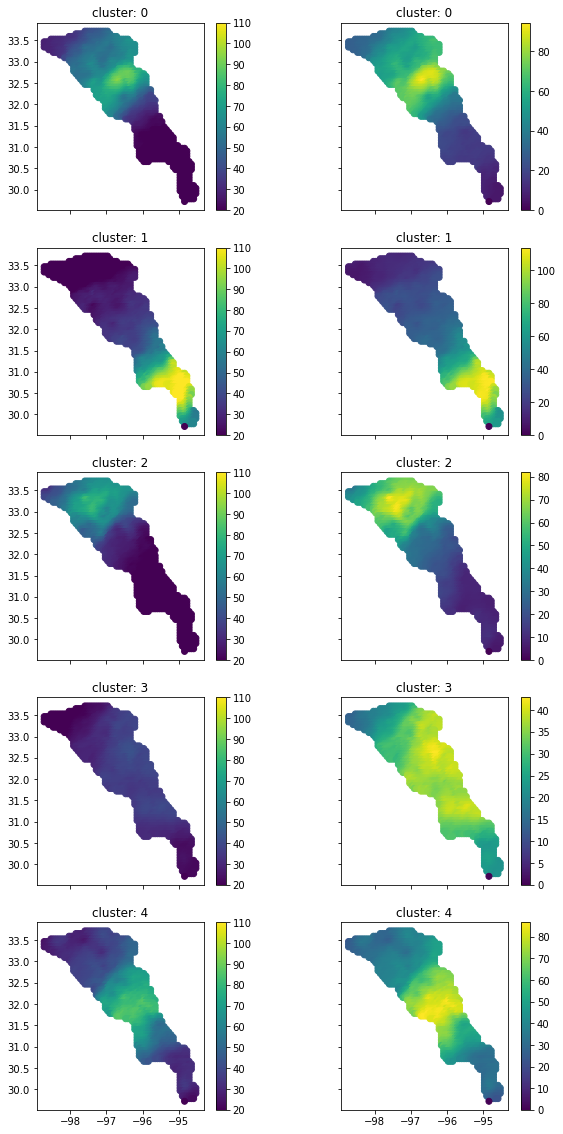

In [15]:

clusters = sum([1 if type(i) is int else 0 for i in cluster_means.columns.values])
fig, axs = plt.subplots(nrows=clusters, ncols=2, figsize=(10, 20), sharex=True, sharey=True)
for column in range(2):
    for cluster in range(clusters):
        cluster_means.plot(ax=axs[cluster, column], column=cluster, vmin=20, vmax=110, legend = True) if column==0 else cluster_means.plot(ax=axs[cluster, column], column=cluster, legend=True)
        axs[cluster, column].set_title(f'cluster: {cluster}')

In [ ]:
print(df.sum(axis=1))